In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

In [2]:
# Load results of the fitting procedure

subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'sketch_tokens'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]
fig_save_folder=None

roi_def = roi_utils.multi_subject_roi_def(subjects)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

In [4]:
# Load information about the sketch tokens features
from utils import default_paths
import scipy.stats
import pandas as pd
from scipy.io import loadmat

cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
feature_ims = clust['clusters']['clusters'][0][0]
feature_ims = np.moveaxis(feature_ims, [0,1,2], [1,0,2])

fn = os.path.join(default_paths.sketch_token_feat_path,\
                  'Sketch_token_feature_curvrect_stats.npy')
stats = np.load(fn, allow_pickle=True).item()
c_means1 = np.mean(np.mean(stats['curv_score_method1'], axis=0), axis=0)
l_means1 = np.mean(np.mean(stats['lin_score_method1'], axis=0), axis=0)

curv_score = scipy.stats.zscore(c_means1)
lin_score = scipy.stats.zscore(l_means1)

dfname = os.path.join(default_paths.sketch_token_feat_path, \
                      'Sketch_tokens_info_table.csv')
df = pd.read_csv(dfname)

estim_bend_values = np.round(np.array(df['best_bend']),4)
estim_orient_values = np.round(np.array(df['best_orient']*180/np.pi),2)
best_linear_index = np.array(df['best_linear_index'])
best_curv_index = np.array(df['best_curv_index'])
which_best = np.array(df['which_best'])

is_single = df['single']
is_straight_line = is_single & (estim_bend_values==0)
is_curved_line = is_single & (estim_bend_values>0)

is_junction = df['junction']
is_double = df['double']
is_other = df['other']

feature_groups = [is_straight_line, is_curved_line, is_double, is_junction, is_other]
feature_group_names = ['straight line', 'curved line', 'double line', 'junction', 'other']

n_features = 150
which_group = np.array([np.where(np.array(feature_groups)[:,ii])[0][0] \
                        for ii in range(n_features)])

freq_values_cyc_per_image = np.linspace(2,7,4)
bend_values = np.round(np.linspace(0, 0.30, 8),4)
orient_values = np.linspace(0,360,73)[0:72]
orient_values = orient_values[0:36]; # simplify by assuming 180/360 are same
n_ori = len(orient_values)
n_bend = len(bend_values)

In [55]:
np.unique(which_group)

array([0, 1, 2, 3, 4])

In [5]:
len(bend_values)

8

In [6]:
# using the corr coef between model resp and feature channel activation as a measure of selectivity.

feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels, n_features = feature_corr.shape

# find maxes. if they are constant across channels, then set to nan.
preferred_feat_corr = np.argmax(feature_corr, axis=1).astype(int)
is_constant = np.all(np.tile(feature_corr[:,0:1], [1,n_features])==feature_corr, axis=1)
assert(not np.any(is_constant))

preferred_ori_corr = np.mod(estim_orient_values[preferred_feat_corr],180);
preferred_group_corr = which_group[preferred_feat_corr];
preferred_bend_corr = estim_bend_values[preferred_feat_corr];

In [7]:
# using the corr coef between model resp and feature channel activation as a measure of selectivity.

feature_weights = np.concatenate([out[si]['best_params'][1][:,:,0] for si in range(n_subjects)], axis=0)
n_voxels, n_features = feature_weights.shape

In [8]:
# find maxes. if they are constant across channels, then set to nan.
preferred_feat_weights = np.argmax(feature_weights, axis=1).astype(int)
is_constant = np.all(np.tile(feature_weights[:,0:1], [1,n_features])==feature_weights, axis=1)
assert(not np.any(is_constant))

preferred_ori_weights = np.mod(estim_orient_values[preferred_feat_weights],180);
preferred_group_weights = which_group[preferred_feat_weights];
preferred_bend_weights = estim_bend_values[preferred_feat_weights];

In [35]:
from utils import prf_utils

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = np.round(sigma * screen_eccen_deg,3)


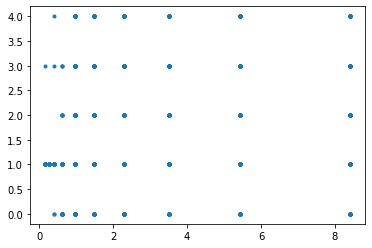

In [36]:
rr = 0;
inds = roi_def.get_indices(ri) & (r2>r2_thresh)
plt.plot(size_fwrf[inds], preferred_group_corr[inds],'.')

In [37]:
un,c = np.unique(size_fwrf,return_counts=True)
c

array([12079,  8347,  9009, 11159, 16545, 26110, 28944, 17703,  9334,
       11612])

In [38]:
un

array([0.168, 0.259, 0.401, 0.619, 0.956, 1.476, 2.28 , 3.522, 5.439,
       8.4  ], dtype=float32)

In [31]:
np.corrcoef(size_fwrf[inds], preferred_group_corr[inds])

array([[1.        , 0.12036393],
       [0.12036393, 1.        ]])

In [73]:
r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
smallest_size = size_fwrf==np.min(size_fwrf)
r2_thresh = 0.01
n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

roi_counts_groups = np.zeros((n_subjects, n_rois,len(feature_groups)),dtype=int)

for si in range(n_subjects):
    
    for ri in range(n_rois):
        # inds = roi_def.get_indices(ri) & (r2>r2_thresh) & smallest_size
        inds = roi_def.get_indices(ri) & (r2>r2_thresh) & (subject_inds==si)
        roi_counts_groups[si,ri,:] = [np.sum(preferred_group_corr[inds]==gg) \
                                           for gg in range(len(feature_groups))]
   
    assert(np.sum(roi_counts_groups[si,ri,:])==np.sum(inds))
    

In [82]:
vals = np.sum(roi_counts_groups, axis=0)
vals.shape

(12, 5)

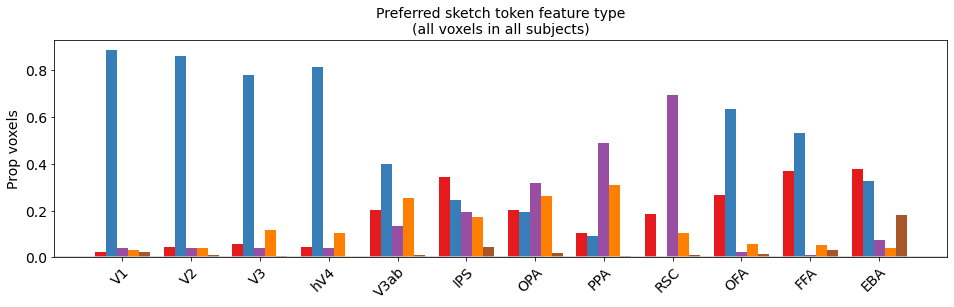

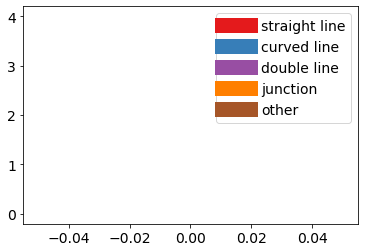

In [85]:
# vals = roi_counts_groups/np.sum(roi_counts_groups, axis=1, keepdims=True)
vals = np.sum(roi_counts_groups, axis=0)
vals = vals/np.sum(vals, axis=1, keepdims=True)
# mean_vals = np.mean(vals, axis=0)
# sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

labels = feature_group_names

colors = cm.Set1(np.linspace(0,1,7))
plot_utils.set_all_font_sizes(14)
fh = plot_utils.plot_multi_bars(mean_data=vals, space=0.1, \
                xticklabels=roi_names, ylabel='Prop voxels', colors=colors[0:5,:], \
                ylim=[], title='Preferred sketch token feature type\n(all voxels in all subjects)', horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))

In [81]:
mean_vals.shape

(12, 5)

In [72]:
vals.shape

(5,)

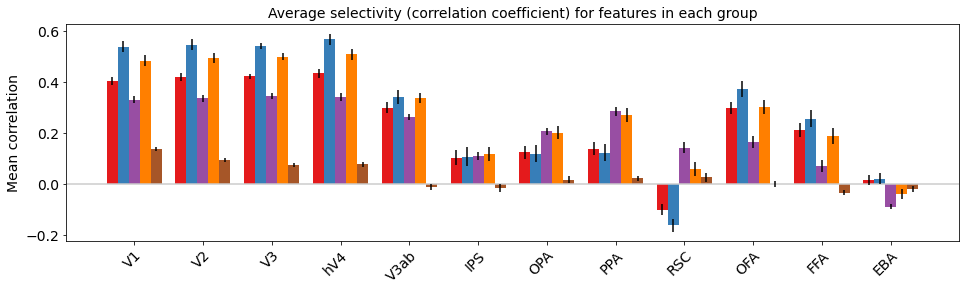

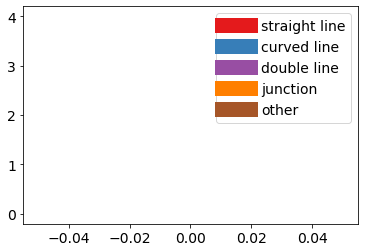

In [80]:
r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
r2_thresh = 0.01
n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

roi_means_groups = np.zeros((n_subjects, n_rois,len(feature_groups)),dtype=float)

for si in range(n_subjects):

    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (r2>r2_thresh) & (subject_inds==si)
        corr_this_roi = np.mean(feature_corr[inds,:], axis=0)

        roi_means_groups[si,ri,:] = [np.mean(corr_this_roi[which_group==gg]) \
                                   for gg in range(len(feature_groups))]

mean_vals = np.mean(roi_means_groups, axis=0)
sem_vals = np.std(roi_means_groups, axis=0) / np.sqrt(n_subjects)

# vals = vals/np.sum(vals, axis=1, keepdims=True)
labels = feature_group_names

colors = cm.Set1(np.linspace(0,1,7))
plot_utils.set_all_font_sizes(14)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, space=0.1, \
                xticklabels=roi_names, ylabel='Mean correlation', colors=colors[0:5,:], \
                ylim=[], \
                title='Average selectivity (correlation coefficient) for features in each group', \
                horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))

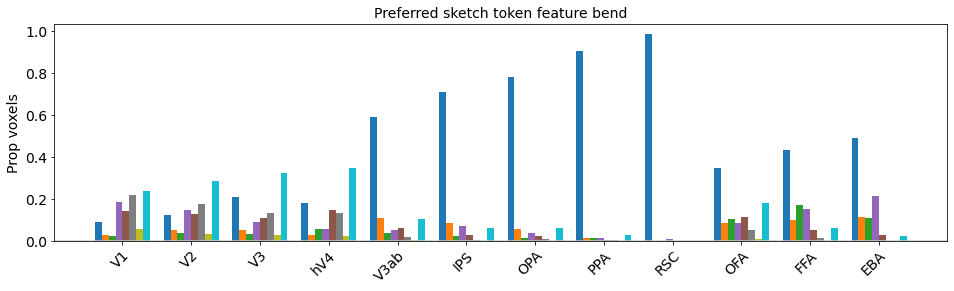

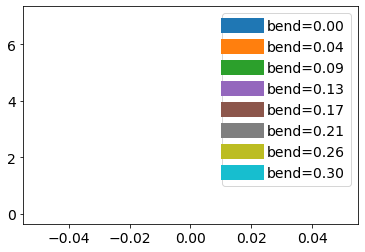

In [42]:
r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
r2_thresh = 0.01
roi_counts_groups = np.zeros((n_rois,n_bend),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri) & (r2>r2_thresh)
    roi_counts_groups[ri,:] = [np.sum(preferred_bend_corr[inds]==bb) \
                               for bb in bend_values]
    # roi_counts_groups[ri,:] = [np.sum(preferred_bend_weights[inds]==bb) \
                               # for bb in bend_values]
    assert(np.sum(roi_counts_groups[ri,:])==np.sum(inds))
    
vals = roi_counts_groups
vals = vals/np.sum(vals, axis=1, keepdims=True)
labels = feature_group_names

plot_utils.set_all_font_sizes(14)
fh = plot_utils.plot_multi_bars(mean_data=vals, space=0.1, \
                xticklabels=roi_names, ylabel='Prop voxels', \
                ylim=[], title='Preferred sketch token feature bend', horizontal_line_pos=0,\
                legend_labels=['bend=%.2f'%bb for bb in bend_values], \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))

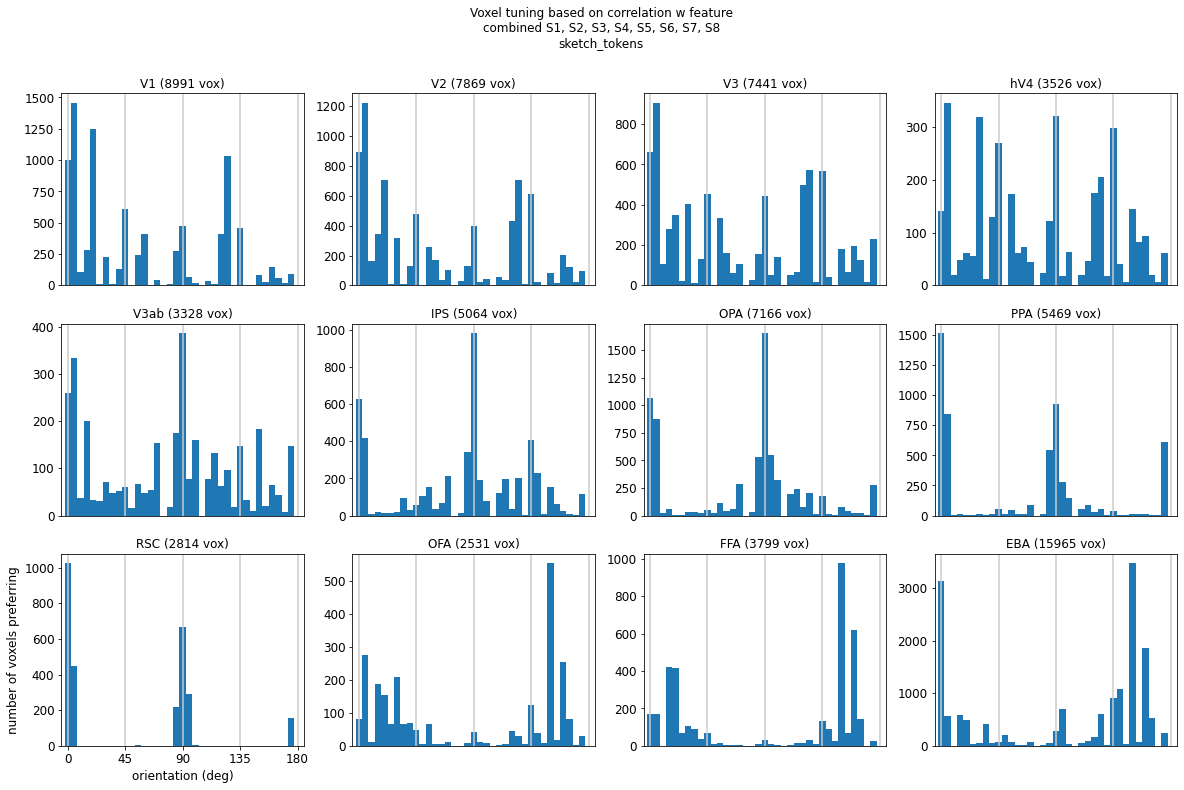

In [11]:
# Plot histograms of "preferred orientation"
# based on correlation coefficient method

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

# inds2use = abv_thresh & (preferred_group_corr==0)
# inds2use = abv_thresh & (preferred_group_corr==1)
inds2use = abv_thresh

plot_utils.set_all_font_sizes(12)
plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & inds2use
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = orient_values[1] - orient_values[0]
    # neach = [np.sum(preferred_ori_weights[inds_this_roi]==orient_values[oo]) \
             # for oo in range(n_ori)]
    neach = [np.sum(preferred_ori_corr[inds_this_roi]==orient_values[oo]) \
             for oo in range(n_ori)]
    plt.bar(orient_values, neach, width=spacing)

    plt.xlim([-spacing, 180+spacing])

    if pi==(npx-1)*npy+1:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\n%s\n%s'%\
             (summary_plots.get_substr(out), fitting_type));


Text(0.5, 0.98, 'Selectivity profile, averaged within ROIs\ncombined S1, S2, S3, S4, S5, S6, S7, S8')

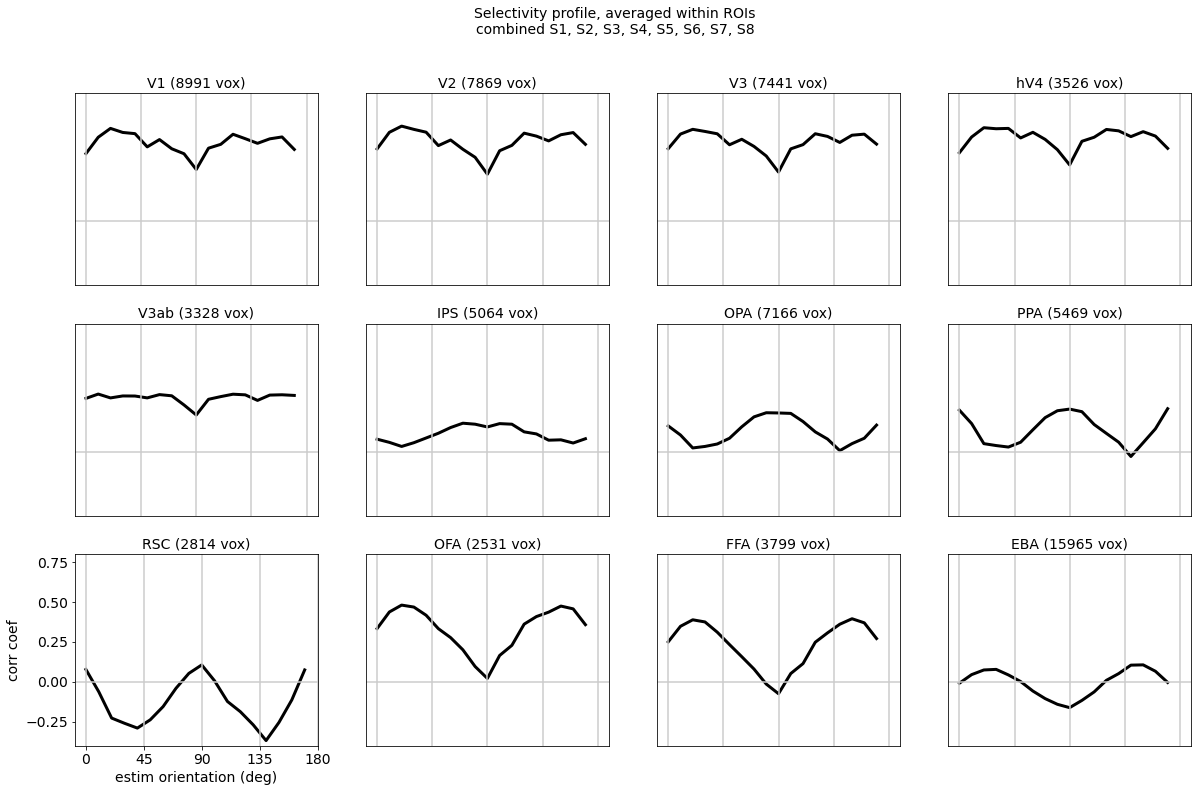

In [54]:
# Plot average orientation tuning curves for each ROI

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

xvals = np.arange(0,180,10)+0.001;
ori = np.round(np.mod(estim_orient_values,180),1);
inds = [(np.abs(ori-xx)<5) | (np.abs(ori-180-xx)<5) for xx in xvals]
sums =[np.sum(ii) for ii in inds]
assert(np.sum(sums)==150)

yvals = np.array([np.mean(feature_corr[:,ii], axis=1) for ii in inds]).T


pi=0
for rr in range(n_rois):
    
    inds_this_roi = roi_def.get_indices(rr) & abv_thresh

    pi+=1
    plt.subplot(npx,npy,pi)

    if np.sum(inds_this_roi)>0:
       
        plt.plot(xvals,  np.mean(yvals[inds_this_roi,:], axis=0),\
                 '-',color='k',linewidth=3)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.4,0.8])

    if pi==(npx-1)*npy+1:
        plt.xlabel('estim orientation (deg)')
        plt.ylabel('corr coef')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
        plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))


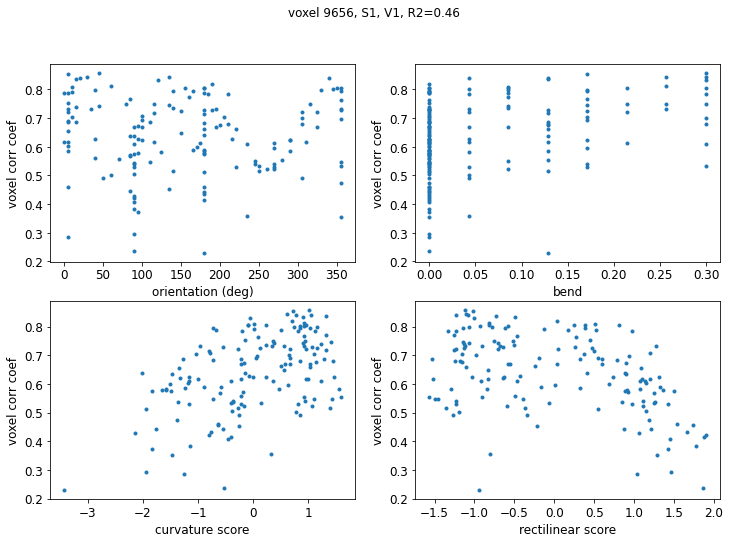

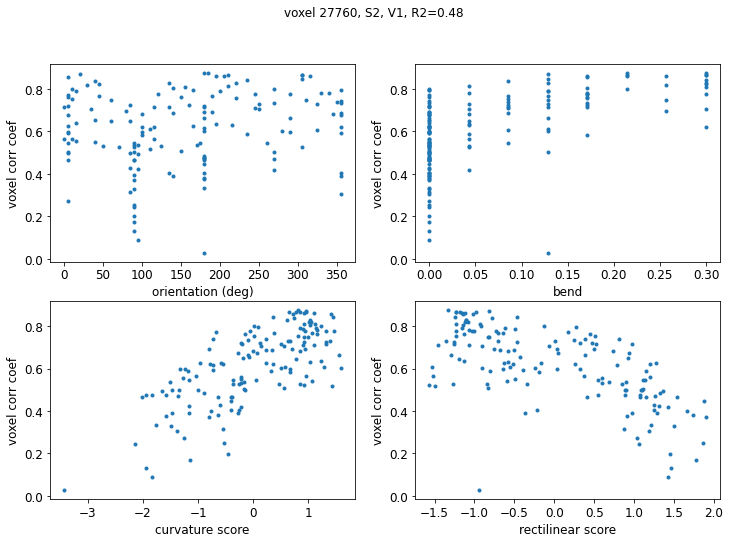

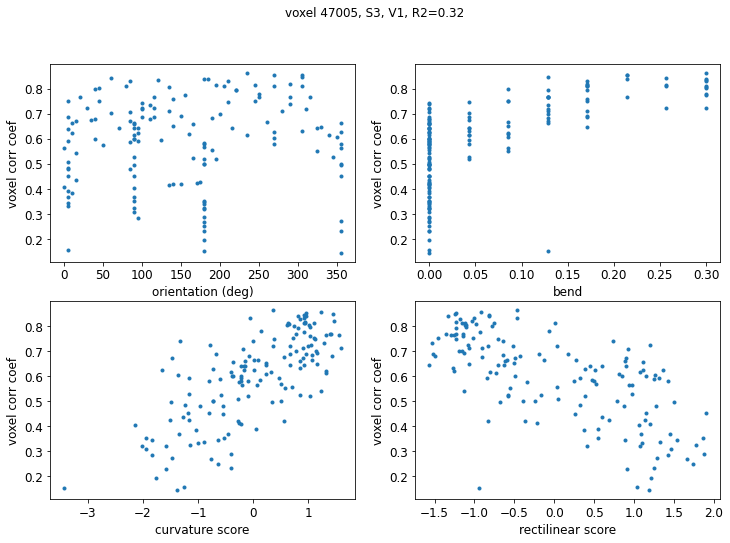

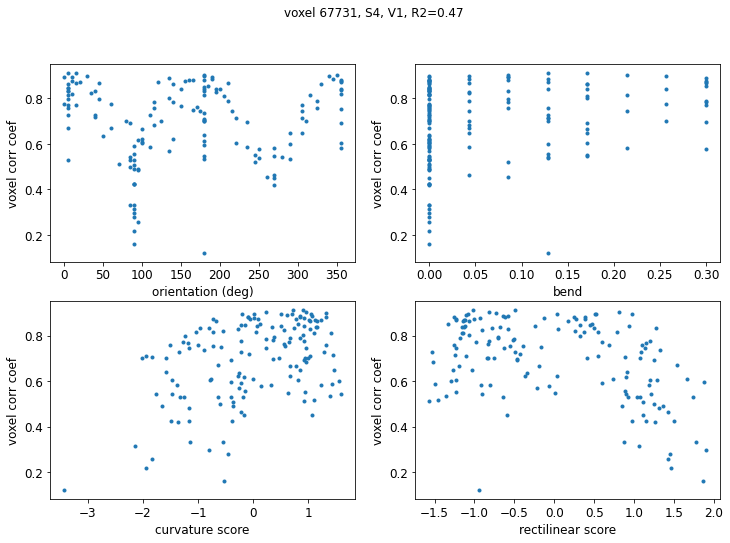

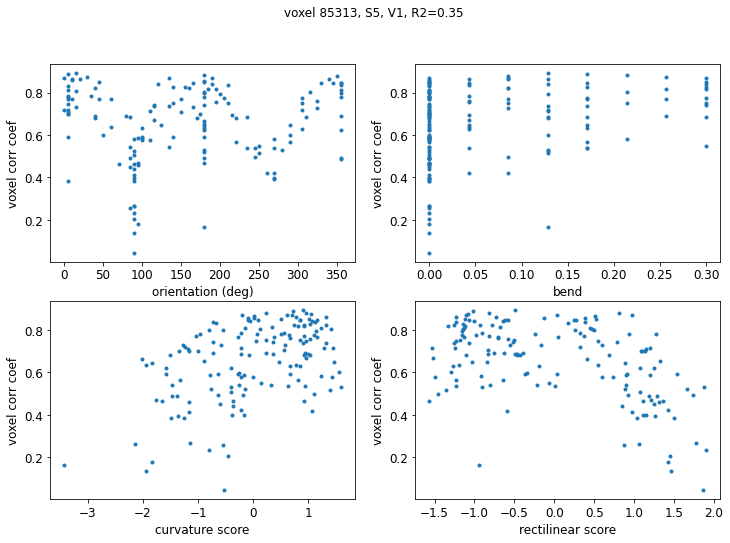

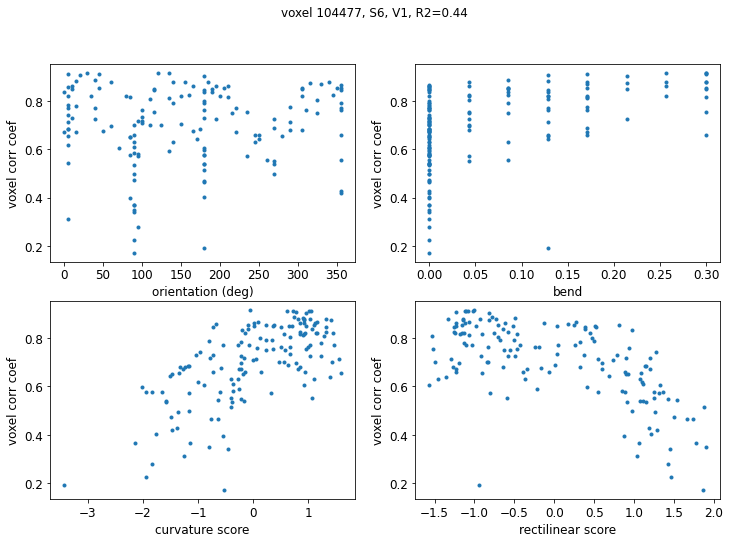

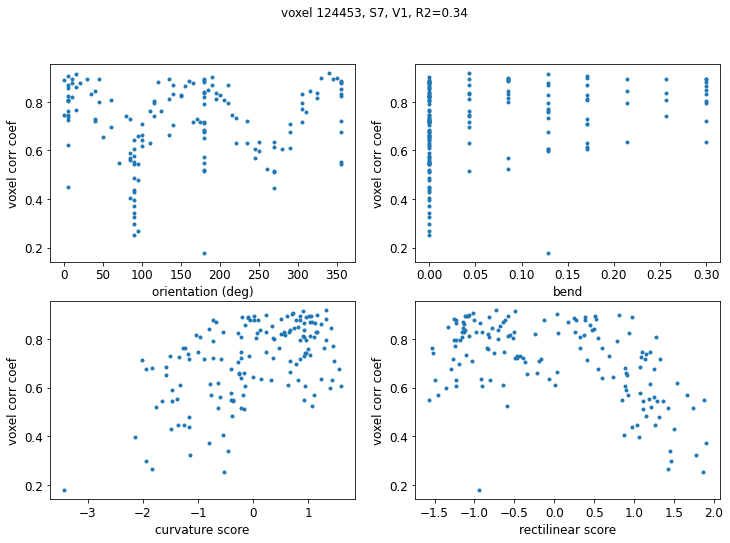

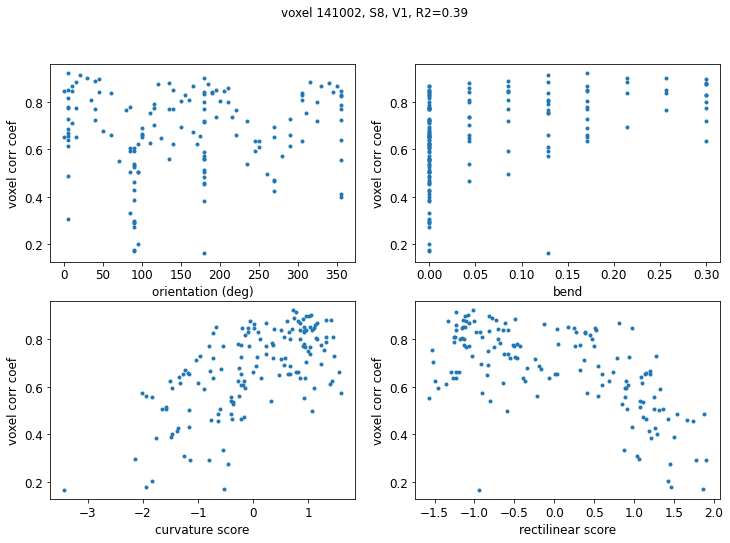

In [17]:
# plot voxel selectivity versus properties of the sketch tokens feature channels

rr = 0;

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

vv_list = []
for si, o in enumerate(out):
    vox2plot = np.where(roi_def.get_indices(rr) & (subject_inds==si))[0]
    vox2plot = vox2plot[np.flip(np.argsort(val_r2[vox2plot]))][0]
    vv_list.append(vox2plot)

for si, vv in enumerate(vv_list):

    plt.figure(figsize=(12,8))

    fc = feature_corr[vv,:]
    
    ori = estim_orient_values;
    
    bend = estim_bend_values;
    
    names = ['orientation (deg)', 'bend', 'curvature score', 'rectilinear score']
    for xx, xvals in enumerate([ori,bend,curv_score,lin_score]):
        
        plt.subplot(2,2,xx+1)
        
        plt.plot(xvals, fc, '.')
        plt.xlabel(names[xx])
        plt.ylabel('voxel corr coef')
    
    plt.suptitle('voxel %d, S%d, %s, R2=%.2f'%(vv, (si+1), roi_def.roi_names[rr], val_r2[vv]))

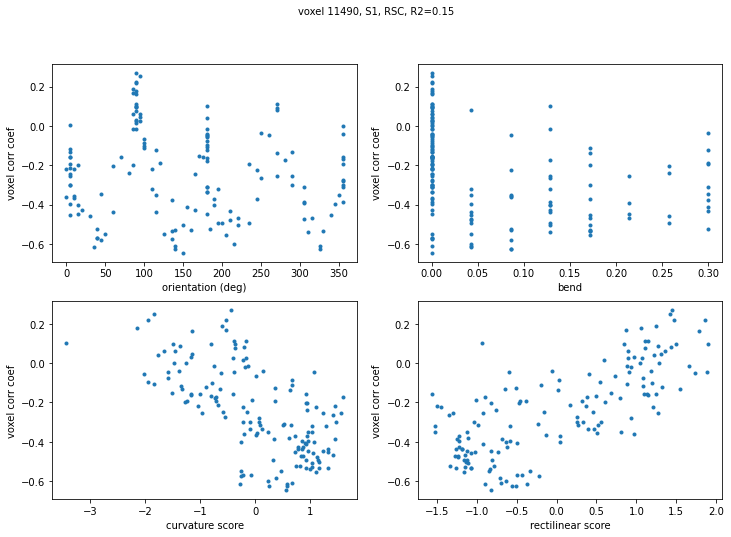

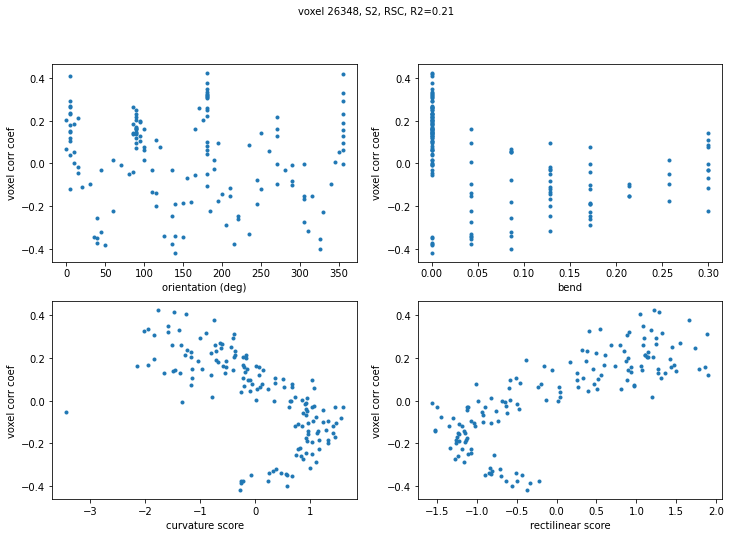

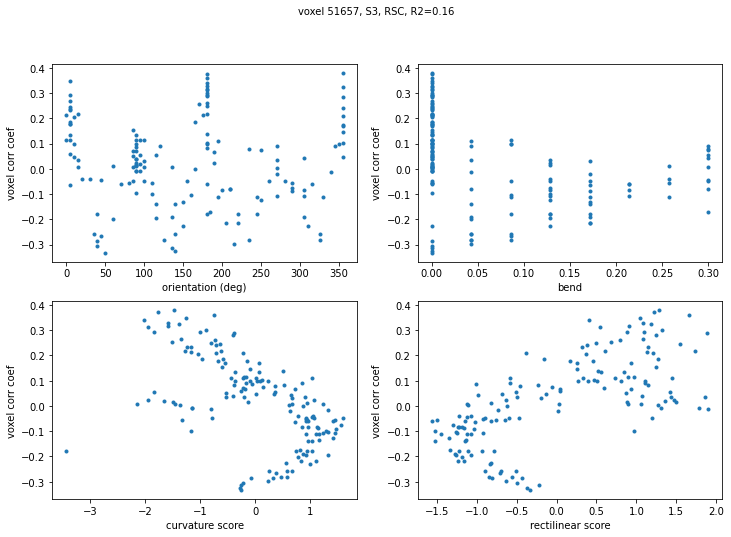

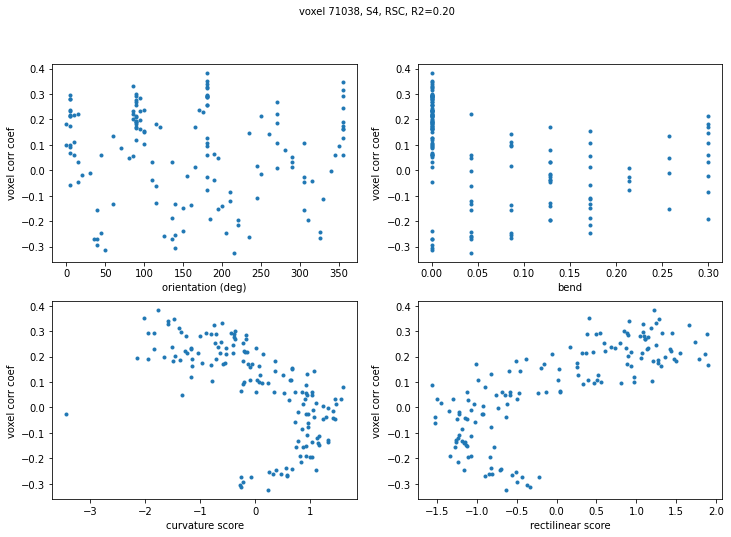

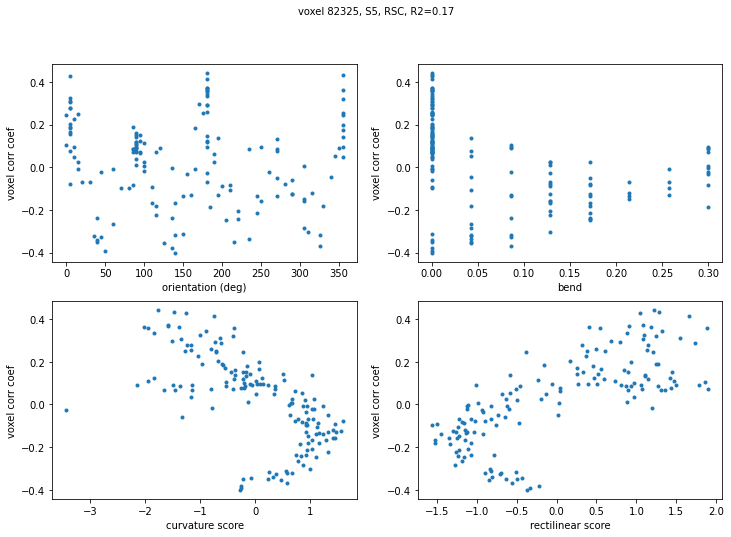

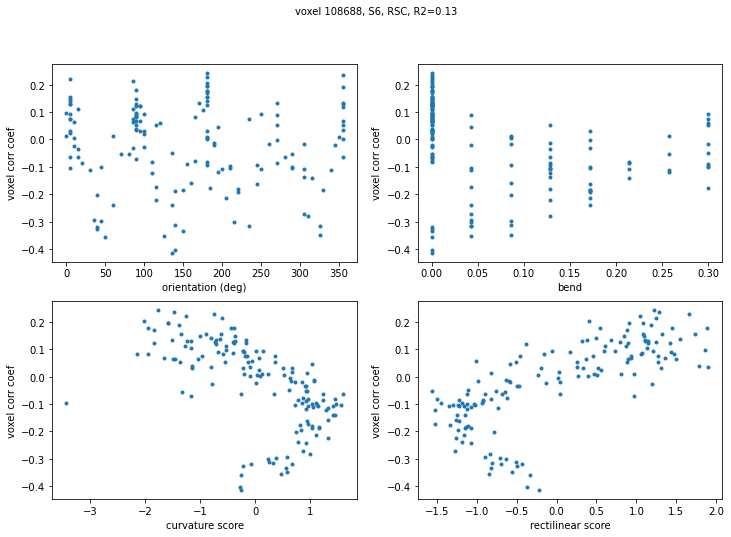

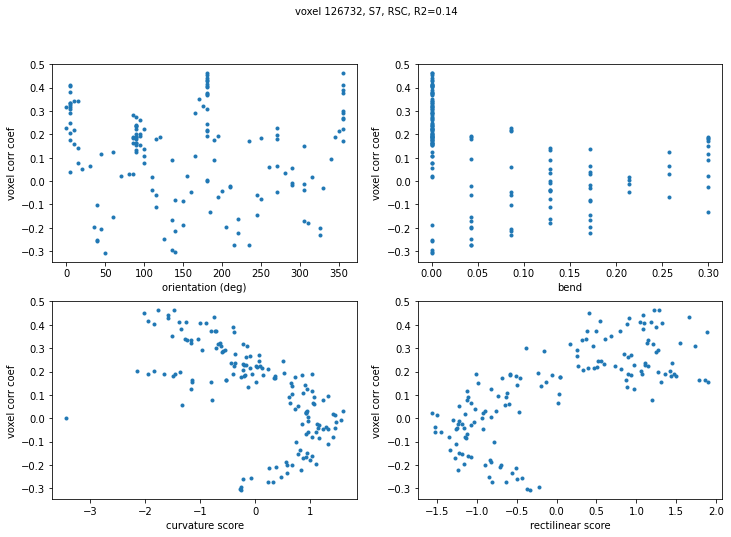

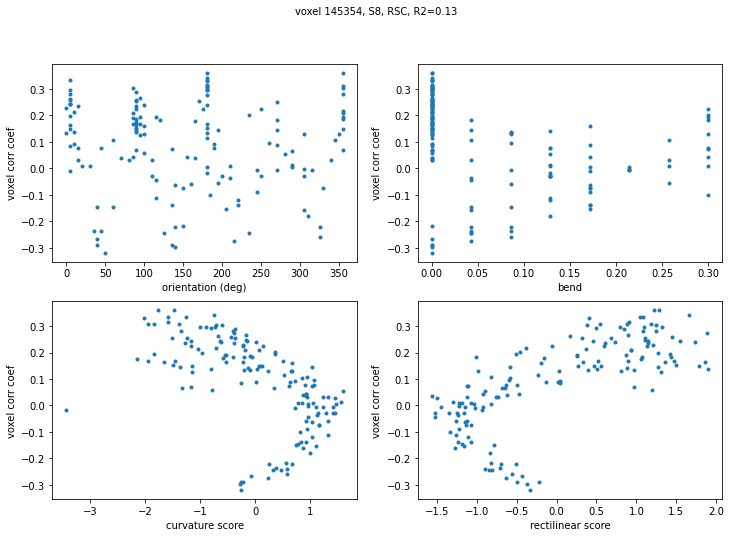

In [24]:
# plot voxel selectivity versus properties of the sketch tokens feature channels

rr = 8;

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

vv_list = []
for si, o in enumerate(out):
    vox2plot = np.where(roi_def.get_indices(rr) & (subject_inds==si))[0]
    vox2plot = vox2plot[np.flip(np.argsort(val_r2[vox2plot]))][0]
    vv_list.append(vox2plot)

for si, vv in enumerate(vv_list):

    plt.figure(figsize=(12,8))

    fc = feature_corr[vv,:]
    
    ori = estim_orient_values;
    
    bend = estim_bend_values;
    
    names = ['orientation (deg)', 'bend', 'curvature score', 'rectilinear score']
    for xx, xvals in enumerate([ori,bend,curv_score,lin_score]):
        
        plt.subplot(2,2,xx+1)
        
        plt.plot(xvals, fc, '.')
        plt.xlabel(names[xx])
        plt.ylabel('voxel corr coef')
    
    plt.suptitle('voxel %d, S%d, %s, R2=%.2f'%(vv, (si+1), roi_def.roi_names[rr], val_r2[vv]))

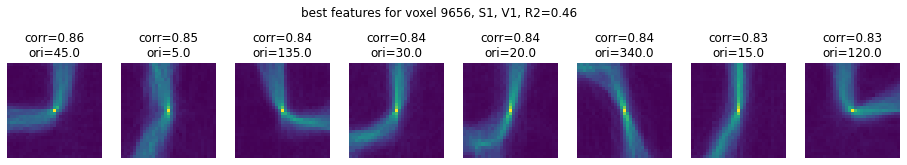

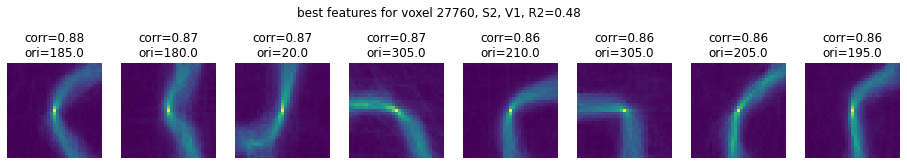

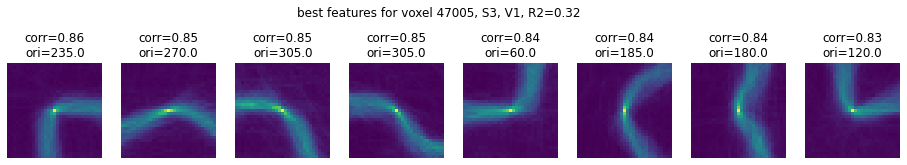

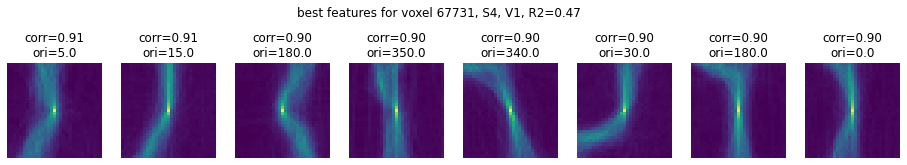

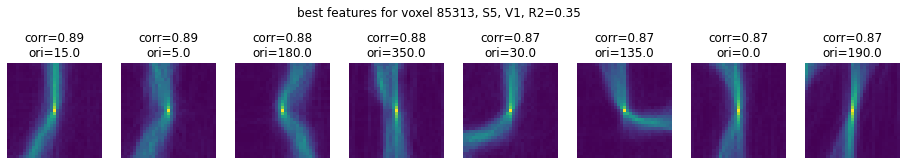

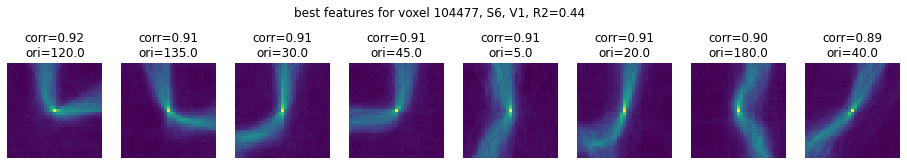

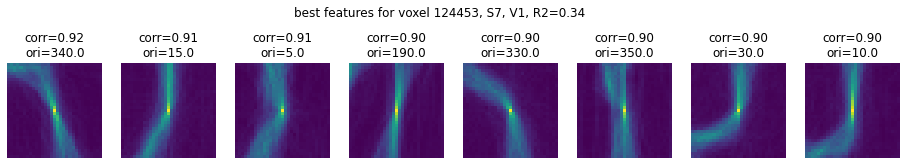

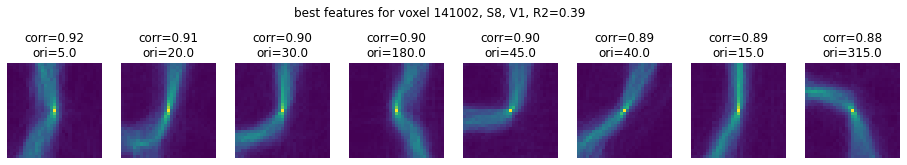

In [20]:
# plot top features for some example voxels
rr = 0;

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

vv_list = []
for si, o in enumerate(out):
    vox2plot = np.where(roi_def.get_indices(rr) & (subject_inds==si))[0]
    vox2plot = vox2plot[np.flip(np.argsort(val_r2[vox2plot]))][0]
    vv_list.append(vox2plot)
    
for si, vv in enumerate(vv_list):

    feat2plot = np.flip(np.argsort(feature_corr[vv,:]))[0:8]
    # feat2plot = np.flip(np.argsort(feature_weights[vv,:]))[0:8]

    plt.figure(figsize=(16,3));
    npx=1;npy=8;
    for fi, ff in enumerate(feat2plot):
        plt.subplot(npx,npy,fi+1)
        plt.pcolormesh(feature_ims[:,:,ff])
        plt.axis('square')
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('corr=%.2f\nori=%.1f'%(np.mean(feature_corr[vv,ff]), estim_orient_values[ff]))

    plt.suptitle('best features for voxel %d, S%d, %s, R2=%.2f'%(vv, (si+1), roi_def.roi_names[rr], val_r2[vv]))


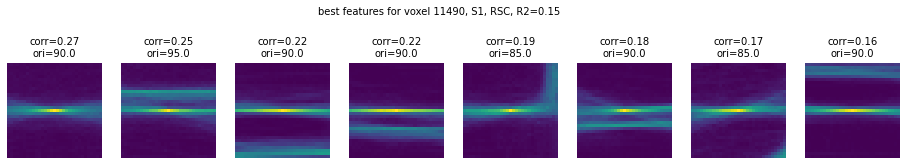

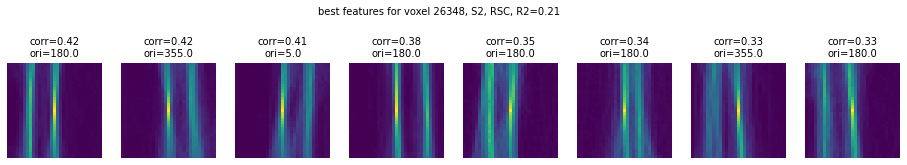

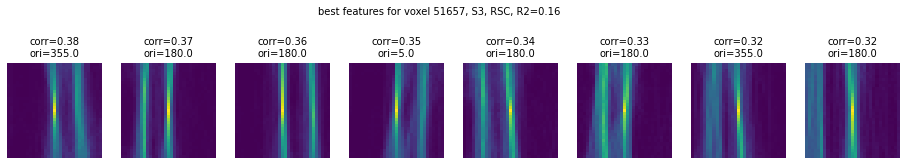

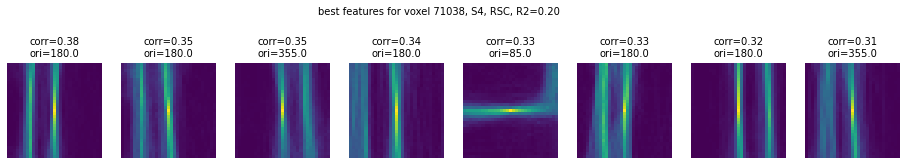

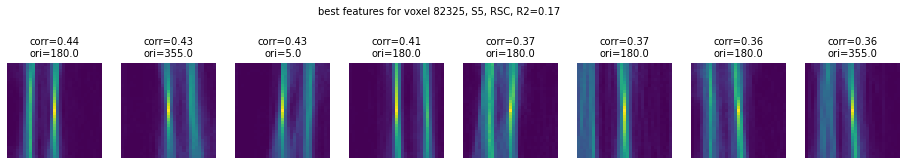

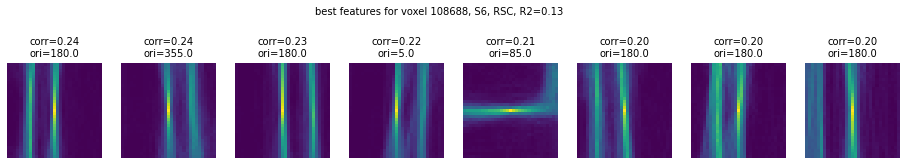

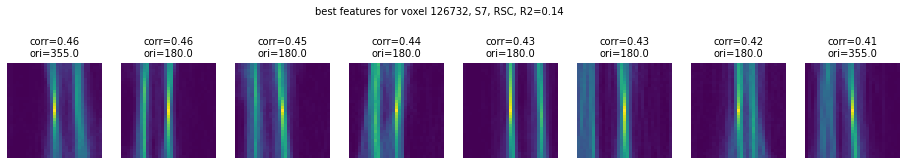

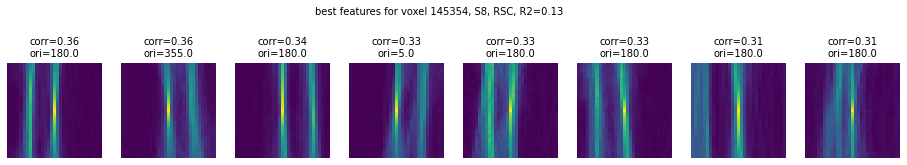

In [26]:
# plot top features for some example voxels
rr = 8;

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

vv_list = []
for si, o in enumerate(out):
    vox2plot = np.where(roi_def.get_indices(rr) & (subject_inds==si))[0]
    vox2plot = vox2plot[np.flip(np.argsort(val_r2[vox2plot]))][0]
    vv_list.append(vox2plot)
    
for si, vv in enumerate(vv_list):

    feat2plot = np.flip(np.argsort(feature_corr[vv,:]))[0:8]
    # feat2plot = np.flip(np.argsort(feature_weights[vv,:]))[0:8]

    plt.figure(figsize=(16,3));
    npx=1;npy=8;
    for fi, ff in enumerate(feat2plot):
        plt.subplot(npx,npy,fi+1)
        plt.pcolormesh(feature_ims[:,:,ff])
        plt.axis('square')
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('corr=%.2f\nori=%.1f'%(np.mean(feature_corr[vv,ff]), estim_orient_values[ff]))

    plt.suptitle('best features for voxel %d, S%d, %s, R2=%.2f'%(vv, (si+1), roi_def.roi_names[rr], val_r2[vv]))


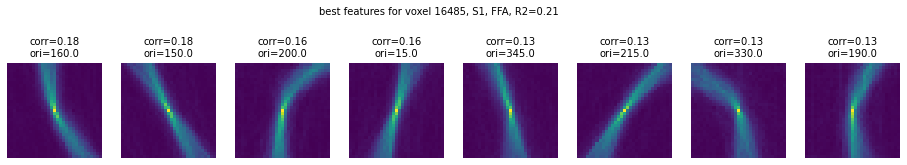

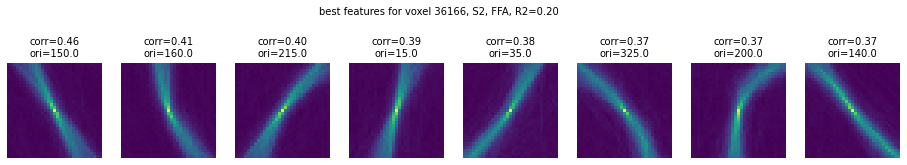

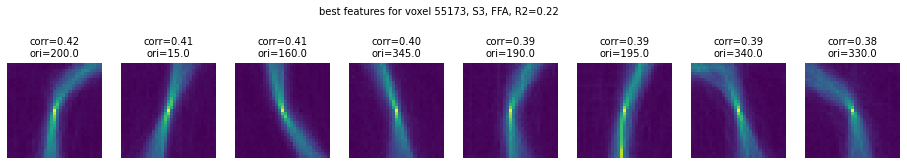

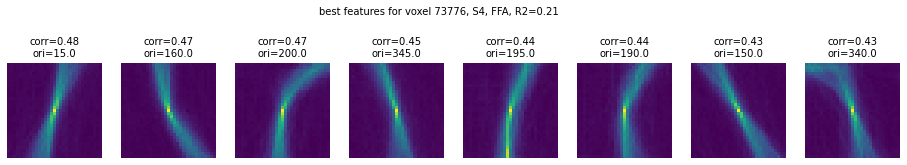

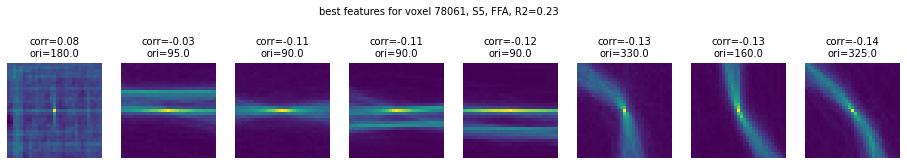

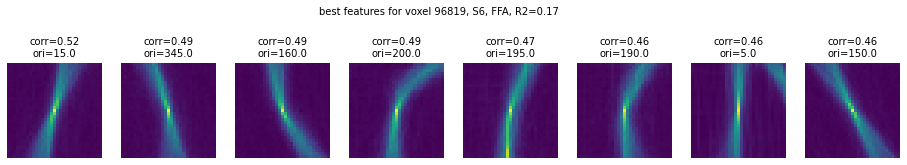

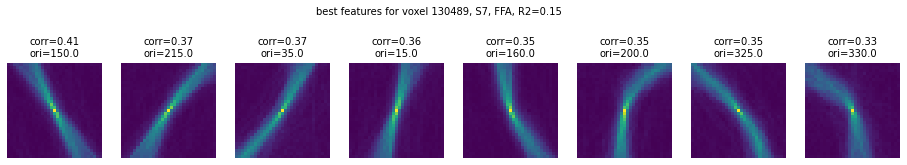

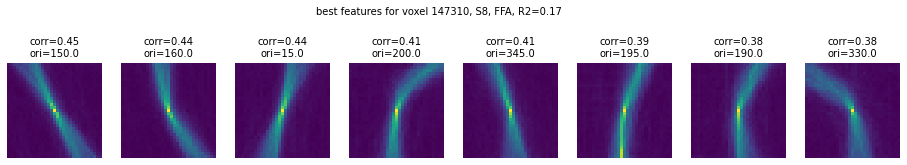

In [27]:
# plot top features for some example voxels
rr = 10;

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

vv_list = []
for si, o in enumerate(out):
    vox2plot = np.where(roi_def.get_indices(rr) & (subject_inds==si))[0]
    vox2plot = vox2plot[np.flip(np.argsort(val_r2[vox2plot]))][0]
    vv_list.append(vox2plot)
    
for si, vv in enumerate(vv_list):

    feat2plot = np.flip(np.argsort(feature_corr[vv,:]))[0:8]
    # feat2plot = np.flip(np.argsort(feature_weights[vv,:]))[0:8]

    plt.figure(figsize=(16,3));
    npx=1;npy=8;
    for fi, ff in enumerate(feat2plot):
        plt.subplot(npx,npy,fi+1)
        plt.pcolormesh(feature_ims[:,:,ff])
        plt.axis('square')
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('corr=%.2f\nori=%.1f'%(np.mean(feature_corr[vv,ff]), estim_orient_values[ff]))

    plt.suptitle('best features for voxel %d, S%d, %s, R2=%.2f'%(vv, (si+1), roi_def.roi_names[rr], val_r2[vv]))


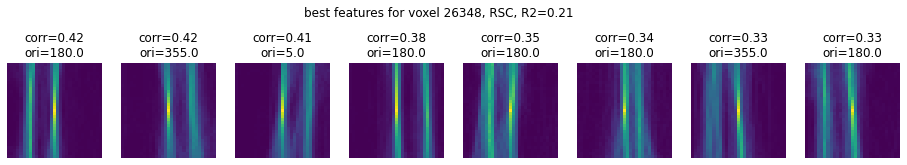

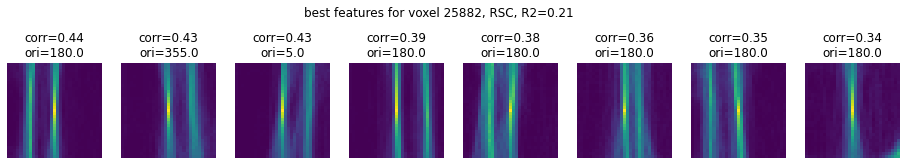

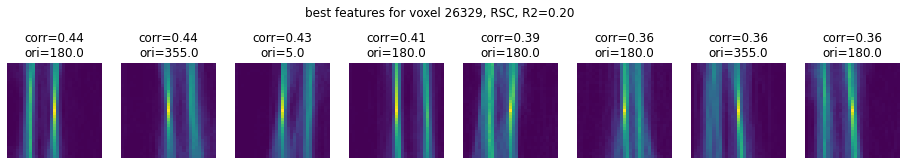

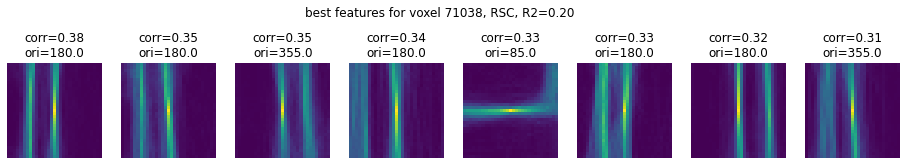

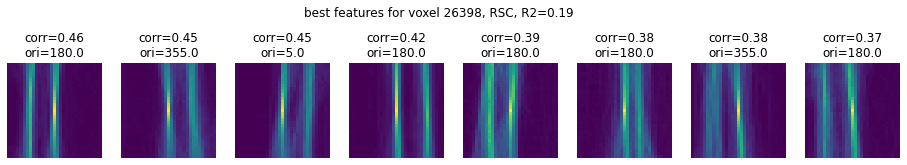

In [95]:
# plot top features for some example voxels
rr = 8;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

vox2plot = np.where(roi_def.get_indices(rr))[0]
vox2plot = vox2plot[np.flip(np.argsort(val_r2[vox2plot]))]
for vi in range(5):

    vv = vox2plot[vi]

    feat2plot = np.flip(np.argsort(feature_corr[vv,:]))[0:8]
    # feat2plot = np.flip(np.argsort(feature_weights[vv,:]))[0:8]

    plt.figure(figsize=(16,3));
    npx=1;npy=8;
    for fi, ff in enumerate(feat2plot):
        plt.subplot(npx,npy,fi+1)
        plt.pcolormesh(feature_ims[:,:,ff])
        plt.axis('square')
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('corr=%.2f\nori=%.1f'%(np.mean(feature_corr[vv,ff]), estim_orient_values[ff]))

    plt.suptitle('best features for voxel %d, %s, R2=%.2f'%(vv, roi_def.roi_names[rr], val_r2[vv]))


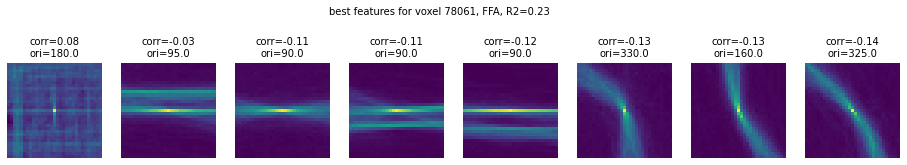

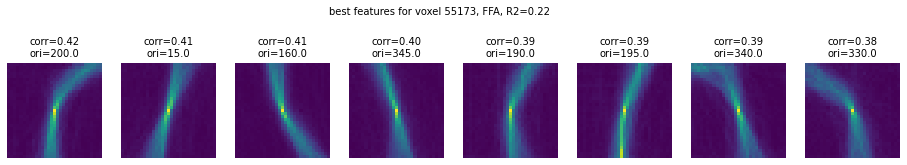

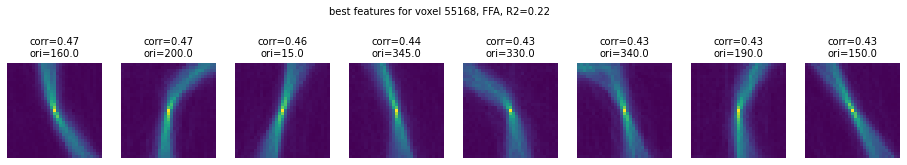

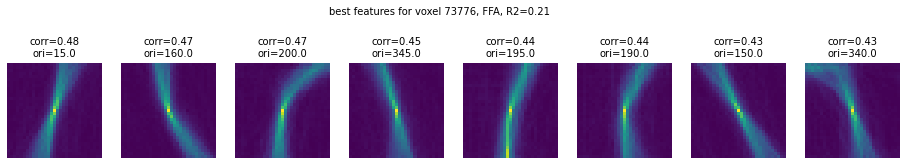

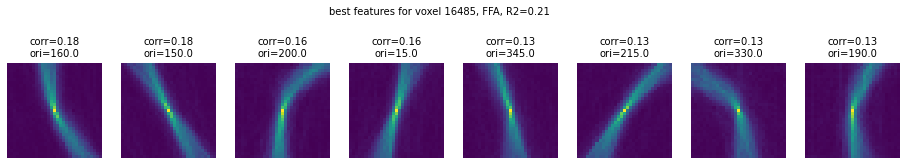

In [25]:
# plot top features for some example voxels
rr = 10;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

vox2plot = np.where(roi_def.get_indices(rr))[0]
vox2plot = vox2plot[np.flip(np.argsort(val_r2[vox2plot]))]
for vi in range(5):

    vv = vox2plot[vi]

    feat2plot = np.flip(np.argsort(feature_corr[vv,:]))[0:8]
    # feat2plot = np.flip(np.argsort(feature_weights[vv,:]))[0:8]

    plt.figure(figsize=(16,3));
    npx=1;npy=8;
    for fi, ff in enumerate(feat2plot):
        plt.subplot(npx,npy,fi+1)
        plt.pcolormesh(feature_ims[:,:,ff])
        plt.axis('square')
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('corr=%.2f\nori=%.1f'%(np.mean(feature_corr[vv,ff]), estim_orient_values[ff]))

    plt.suptitle('best features for voxel %d, %s, R2=%.2f'%(vv, roi_def.roi_names[rr], val_r2[vv]))
